## Image Segmentation using Graph Theory

This notebook implements a binary segmentation method based on graph theory. The idea is to write down the segmentation problem as a graph problem, a graph cut problem to be precise. First we build a graph G whose nodes are pixels of the image we want to segment in addition to two nodes representing the background and the foreground of the image, then we perform the graph cut to get two sets of disconected nodes.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from PIL import Image
np.random.seed(7)

## Loading Images

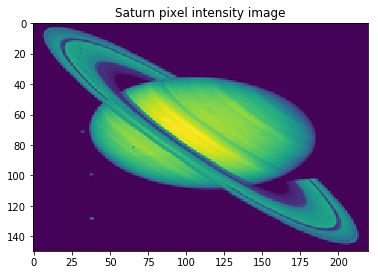

In [64]:
# This is the image we would like to segment, so we want to find the contour of planet ...
im = Image.open("./images/saturn.jpg")

# Let's downsize the image to be 130 by 80 pixels for example
height, width = 150, 220
im = im.resize((width, height), Image.ANTIALIAS)

# We will be working with numpy to make computations easy
myIm = np.asarray(im)
length, width = myIm.shape

plt.figure(figsize=(6,5))
plt.imshow(myIm)
plt.title('Saturn pixel intensity image')
plt.show()

## Visualizing intensity histogram

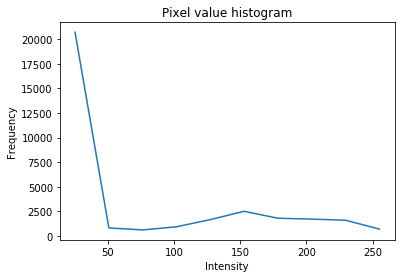

In [65]:
frequencies, intensities = np.histogram(myIm)
# Make both arrays of the same size
intensities = intensities[1:]

plt.plot(intensities, frequencies)
plt.title("Pixel value histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

## Getting pixel samples from background and foreground
Instead of requiring the user scribles as input we will be using a threshold value to separate to pixel samples in order to estimate intenssity distributions.

In [66]:
threshold = 55

background = []
foreground = []

for line in myIm:
    for pixel in line:
        if pixel > threshold:
            foreground.append(pixel)
        else:
            background.append(pixel)

# Sampling 10% of the pixels
background = np.array(background[::10])
foreground = np.array(foreground[::10])
print("Pixels in Background : ", len(background))
print("Pixels in Foreground : ", len(foreground))

Pixels in Background :  2163
Pixels in Foreground :  1137


## Modeling the distribution of background and foreground intensity as gaussians

In [67]:
muB = background.mean()
muF = foreground.mean()
sigmaB = background.std()
sigmaF = foreground.std()

print("Background intensity average : ", muB)
print("Foreground intensity average : ", muF)

print("Background standard deviation : ", sigmaB)
print("Foreground standard deviation : ", sigmaF)

Background intensity average :  3.6102635228848823
Foreground intensity average :  157.14423922603342
Background standard deviation :  7.476096973636683
Foreground standard deviation :  47.103437374144164


## Visualizing the Gaussians

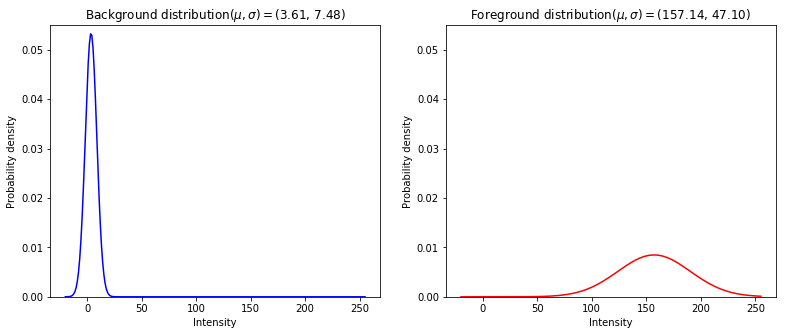

In [68]:
xAxis = np.linspace(-20, 255, 250)

def pdf(x, mu, sig):
    return np.exp(-(x - mu)**2 / (sig**2)) / (np.sqrt(2*np.pi)*sig)

# Computing the PDFs for Background and Foreground
pdfB = [pdf(x, muB, sigmaB) for x in xAxis]
pdfF = [pdf(x, muF, sigmaF) for x in xAxis]

plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
plt.plot(xAxis, pdfB, 'b')
plt.title('Background distribution$(\mu , \sigma) = $({0:.2f}, {1:.2f})'.format(muB, sigmaB))
plt.ylim(0, 0.055)
plt.xlabel('Intensity')
plt.ylabel('Probability density')

plt.subplot(1, 2, 2)
plt.plot(xAxis, pdfF, 'r')
plt.title('Foreground distribution$(\mu , \sigma) = $({0:.2f}, {1:.2f})'.format(muF, sigmaF))
plt.ylim(0, 0.055)
plt.xlabel('Intensity')
plt.ylabel('Probability density')
plt.show()

## Building the graph

This graph will contain two diffrent kinds of nodes :
- The ones called terminal nodes (source and sink)
- The non-terminal nodes that will be representing pixels

Similarly there are two types of edges : 
- Non-terminal edges i-e among non-terminal nodes (will be contained in the grid) 
- Terminal edges, these are edges that link a terminal node with a non-terminal node

A weight will be assigned to each edge according to the neighbors similarity when it comes to non-terminal edges, and for terminal edges the weights will be set according to the probabilistic model that was infered from the user's scribles (or according to the threshold). The idea is then to select a graph cut $\hat c$ that minimizes some energy function $E$ : 

$\hspace{8cm}
\begin{cases}
\hat c = \argmin_c E(c)\\  
E(c)= \lambda R(c) + B(c)
\end{cases}
$.

## Setting the weights for non-terminal edges

In [69]:
myGraph = nx.grid_2d_graph(length, width)
myGraph.add_node('F')
myGraph.add_node('B')


# Building links between non-terminal nodes
for (xA, yA), (xB, yB) in myGraph.edges:
    capacity = (int(myIm[xA][yA]) - int(myIm[xB][yB]))**2
    myGraph.add_edge((xA, yA), (xB, yB), capacity=capacity)

## Setting the weights for terminal edges

In [70]:
epsilon = 0.0001

for node in myGraph.nodes:
    if node != 'F' and node != 'B':
        xNode, yNode = node

        pixel = myIm[xNode][yNode]
        myGraph.add_edge((xNode, yNode), 'F', capacity=-np.log(pdf(pixel, muB, sigmaB) + epsilon))
        myGraph.add_edge((xNode, yNode), 'B', capacity=-np.log(pdf(pixel, muF, sigmaF) + epsilon))